In [ ]:
# Predictive model for identifying potential vip customers


import pandas as pd
import numpy as np


df = pd.read_csv('final.csv', delimiter=",", encoding='ISO-8859-1')



<ipython-input-39-6a4a1f3ab809>:8: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final.csv', delimiter=",", encoding='ISO-8859-1')


In [ ]:
df = df[df['store_region'] == 'BARISAL']  # business can input their store_region of interest


# ensuring 'Purchase_date' and 'Delivery_date' is of proper datetime type
df['purchase_date'] = pd.to_datetime(df['purchase_date'])




# Create new features, also known as feature engineering
customer_info = df.groupby('customer_key')['total_price'].sum().reset_index()
customer_info.columns = ['customer_key', 'total_spent']
customer_purchases = df.groupby('customer_key')['purchase_date'].count().reset_index()
customer_purchases.columns = ['customer_key', 'total_purchases']
customer_info = pd.merge(customer_info, customer_purchases, on='customer_key')
customer_info['avg_purchase_value'] = customer_info['total_spent'] / df.groupby('customer_key')['quantity_purchased'].sum().values


# Preview the engineered features
print(customer_info)


     customer_key  total_spent  total_purchases  avg_purchase_value
0         C000001        587.0                6           17.264706
1         C000002       1456.0               11           18.430380
2         C000003        344.0                4           15.636364
3         C000004       1275.0                7           20.238095
4         C000005        326.0                3           19.176471
...           ...          ...              ...                 ...
9182      C009187        881.0                8           18.744681
9183      C009188        915.0                7           18.673469
9184      C009189        791.0                8           15.820000
9185      C009190       1509.0               13           15.397959
9186      C009191       1106.0                8           16.757576

[9187 rows x 4 columns]


In [ ]:
# Define VIP customers as the top 10% of spenders, using total_spent as threshold
vip_threshold = customer_info['total_spent'].quantile(0.90)
customer_info['is_vip'] = customer_info['total_spent'].apply(lambda x: 1 if x >= vip_threshold else 0)

# Preview the dataset with VIP labels
print(customer_info.head())

# See who are the current VIPs
filtered_rows = customer_info[customer_info['is_vip'] == 1]

print(filtered_rows)




  customer_key  total_spent  total_purchases  avg_purchase_value  is_vip
0      C000001        587.0                6           17.264706       0
1      C000002       1456.0               11           18.430380       1
2      C000003        344.0                4           15.636364       0
3      C000004       1275.0                7           20.238095       0
4      C000005        326.0                3           19.176471       0
     customer_key  total_spent  total_purchases  avg_purchase_value  is_vip
1         C000002       1456.0               11           18.430380       1
10        C000011       1381.0               11           20.611940       1
18        C000019       1398.0               10           18.155844       1
35        C000036       1498.0               11           20.805556       1
46        C000047       1881.0               14           22.662651       1
...           ...          ...              ...                 ...     ...
9146      C009151       1915.0

In [ ]:
from sklearn.model_selection import train_test_split
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier #chose randomforest as it is very robust to imbalanced data, like in this case


# incorporating more feature columns so that the RandomForestClassifier does not memorise the data because only total_spent was used as threshold to define vips
X = customer_info[['total_purchases','total_spent', 'avg_purchase_value']]
y = customer_info['is_vip']

# Initialize the Random Forest classifier with regularization parameters
model = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=38, class_weight='balanced')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

# Initialize smote to training data only to prevent leakage
smote = SMOTE(random_state=38)
X_smoted, y_smoted = smote.fit_resample(X_train, y_train)


In [ ]:
from sklearn.metrics import classification_report


# Train the model
model.fit(X_smoted, y_smoted)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2487
           1       0.74      0.96      0.84       270

    accuracy                           0.96      2757
   macro avg       0.87      0.96      0.91      2757
weighted avg       0.97      0.96      0.97      2757



In [ ]:
# Predict VIP customers on new data
customer_info['predicted_vip'] = model.predict(X)

# Show potential VIP customers
potential_vip = customer_info[customer_info['predicted_vip'] == 1]
potential_vip

# The model was performing too suspiciously perfect, there seems
# to be a problem of class imbalance, where the class of 0 significantly
# outnumbers the class of 1. To fix this, I used SMOTE to oversample
# the minority class to balance the dataset. There was also the issue of
# bias-variance tradeoff when setting the RandomForestClassifier parameters

,customer_key,total_spent,total_purchases,avg_purchase_value,is_vip,predicted_vip
1,C000002,1456.0,11,18.430380,1,1
10,C000011,1381.0,11,20.611940,1,1
14,C000015,1281.0,11,17.791667,0,1
18,C000019,1398.0,10,18.155844,1,1
35,C000036,1498.0,11,20.805556,1,1
...,...,...,...,...,...,...
9149,C009154,1194.0,12,17.304348,0,1
9162,C009167,1786.0,11,23.813333,1,1
9173,C009178,1506.0,11,25.100000,1,1
9178,C009183,1526.0,11,20.346667,1,1


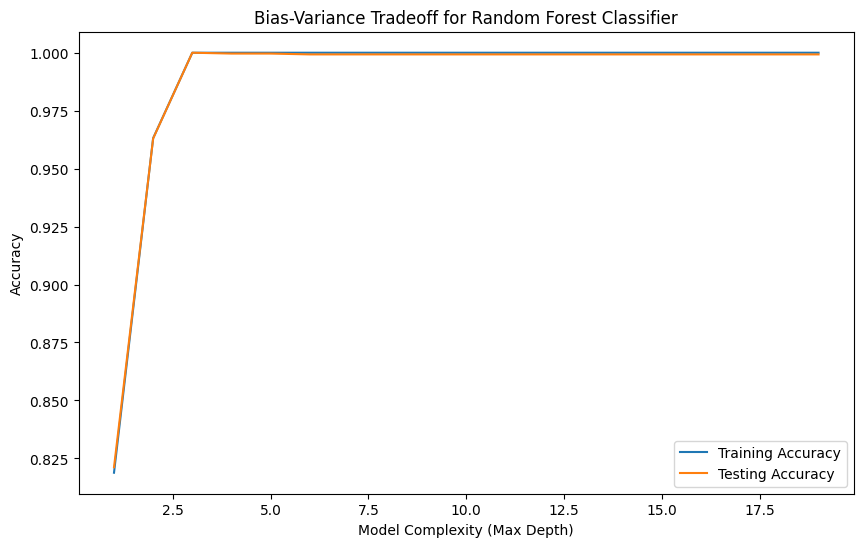

In [ ]:
# BIAS-VARIANCE TRADEOFF GRAPH (NOT THE CLASSIC ONE) TO DETERMINE OPTIMUM DEPTH OF TREE/MODEL COMPLEXITY

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

# Lists to store the scores
train_accuracy = []
test_accuracy = []
max_depth_range = range(1, 20)

# Loop over different values of max_depth
for max_depth in max_depth_range:
    model = RandomForestClassifier(n_estimators=10, max_depth=max_depth, random_state=38, class_weight='balanced')
    model.fit(X_train, y_train)

    # Predict on train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

# Plot the bias-variance tradeoff
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_accuracy, label='Training Accuracy')
plt.plot(max_depth_range, test_accuracy, label='Testing Accuracy')
plt.xlabel('Model Complexity (Max Depth)')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Tradeoff for Random Forest Classifier')
plt.legend()
plt.show()

# This graph does not show the "bias error" or "variance error" explicitly, only the overall performance.
# If accuracy were lower across both training and testing sets (especially at low complexity), it would indicate high bias.
# If training accuracy is high but testing accuracy drops as complexity increases, it would indicate high variance (overfitting).
